In [1]:
import numpy as np
import matplotlib.pyplot as plt
from esmda import ES 

## STEP 1 - define required functions

In [2]:
## define toy forward model (X -> sin(X))
# in the real application, inputs should be geospatial info. (e.g., porosity, fracture, etc)
# ... and Y will be outcomes from geothermal/reservoir simulation (e.g., temperature, pressure, enthalpy)
def forward(a, b):
    """
    This forward model accepts two parameters and returns the sinusoidal function sin(X/a + b).

    Args:
        a (float): Relaxation parameter.
        b (float): Translation parameter.

    Returns:
        np.array: Sinusoidal values calculated for X in the range [0, 2*pi].
    """
    X = np.linspace(0,np.pi,50)/a + b
    Y = np.sin(X)
    return Y

def get_observation(Y):
    """ 
    Selects observations from the entire set of simulation/forward outcomes.

    Args:
        Y (np.array): Array containing simulation results.

    Returns:
        np.array: Subset of simulation results, including only every 10th element.
    """
    return Y[::10]

## STEP 2 - generate ground truth

Text(0, 0.5, 'response/observation')

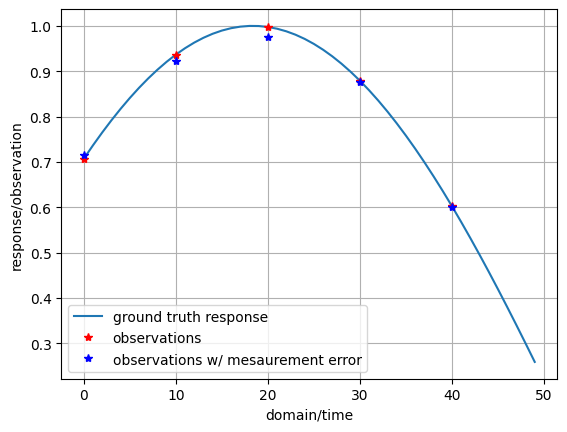

In [17]:
# make ground truth case
ground_truth_a = 1.5
ground_truth_b = np.pi/4

ground_truth_Y = forward(ground_truth_a, ground_truth_b)
ground_truth_OBS = get_observation(ground_truth_Y)
ground_truth_OBS_with_noise = ground_truth_OBS * (1 + np.random.normal(0,0.02,ground_truth_OBS.shape))

obs_loc = np.linspace(0,50,51)[::10][:-1]

plt.plot(ground_truth_Y, label = 'ground truth response')
plt.plot(obs_loc, ground_truth_OBS, 'r*', label = 'observations')
plt.plot(obs_loc, ground_truth_OBS_with_noise, 'b*', label = 'observations w/ mesaurement error')

plt.grid('on')
plt.legend()
plt.xlabel('domain/time')
plt.ylabel('response/observation')

## STEP 3 - generate ensemble

shape of ensemble = (250, 2)


Text(0.5, 0, 'b')

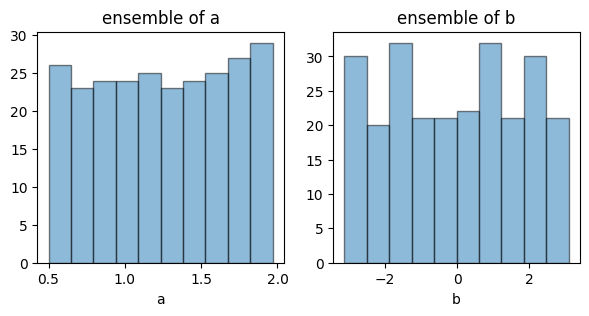

In [18]:
# make ensemble 
num_of_ensemble = 250
range_of_a = [0.5, 2]
range_of_b = [-np.pi, np.pi]

ensemble = []
for i in range(num_of_ensemble):
    a = np.random.uniform(low = range_of_a[0],high = range_of_a[1])
    b = np.random.uniform(low = range_of_b[0],high = range_of_b[1])
    ensemble.append([a, b])

ensemble = np.array(ensemble)
print(f'shape of ensemble = {ensemble.shape}')

plt.figure(figsize = (7,3))

plt.subplot(1,2,1)
plt.hist(ensemble[:,0], edgecolor = 'k', alpha = 0.5)
plt.title('ensemble of a')
plt.xlabel('a')

plt.subplot(1,2,2)
plt.hist(ensemble[:,1], edgecolor = 'k', alpha = 0.5)
plt.title('ensemble of b')
plt.xlabel('b')

## STEP 4 - check ES then run ES-MDA

In [19]:
?ES

Signature:
ES(
    OBS,
    static,
    dynamic,
    alpha=1,
    stdErrOfDynamic_percentage=0.05,
    add_noise=False,
)
Docstring:
Ensemble Smoother function that assimilates observations into an ensemble.

Parameters:
OBS (numpy.ndarray): Array of observations.
static (numpy.ndarray): Array of static variables. should be provided (number of ensemble x number of static variables).
dynamic (numpy.ndarray): Array of dynamic variables. should be provided (number of ensemble x number of dynamic variables).
alpha (float): Smoothing factor (default is 1).
stdErrOfDynamic (float): Standard error of dynamic variables (default is 0.1).
add_noise (bool): Add noise to dynamic variables (default is False).

Returns:
numpy.ndarray: Array of updated static variables.
File:      c:\users\jhg13\downloads\esmda.py
Type:      function

In [22]:
# run esmda
num_of_iteration = 4
alpha = [20 for i in range(num_of_ensemble)]
stdErrOfDynamic_percentage = 0.02

ensemble_by_iteration = [ensemble]

# start of iteration
for iter in range(num_of_iteration):
    # get my current ensemble
    ensemble_static = ensemble_by_iteration[-1]

    # make prediction of ensemble
    ensemble_dynamic = []
    for i in range(num_of_ensemble):
        a = ensemble_static[i,0]
        b = ensemble_static[i,1]
        Y = forward(a, b)
        dynamic = get_observation(Y)
        ensemble_dynamic.append(dynamic)
    ensemble_dynamic = np.array(ensemble_dynamic)
    
    # assimilate ensemble
    updated_ensemble = ES(OBS = ground_truth_OBS_with_noise, 
                          static = ensemble_static, 
                          dynamic = ensemble_dynamic,
                          alpha = alpha[iter],
                          stdErrOfDynamic_percentage = stdErrOfDynamic_percentage,)
    
    # in case updated value exceed the range
    flag = updated_ensemble[:,0] < range_of_a[0]
    updated_ensemble[flag,0] = range_of_a[0]
    flag = updated_ensemble[:,0] > range_of_a[1]
    updated_ensemble[flag,0] = range_of_a[1]
    flag = updated_ensemble[:,1] < range_of_b[0]
    updated_ensemble[flag,0] = range_of_b[0]
    flag = updated_ensemble[:,1] > range_of_b[1]
    updated_ensemble[flag,0] = range_of_b[1]


    # record the updated ensemble before going to next iteration
    ensemble_by_iteration.append(updated_ensemble)

## STEP 5 - visualize results

(-4.1887902047863905, 4.1887902047863905)

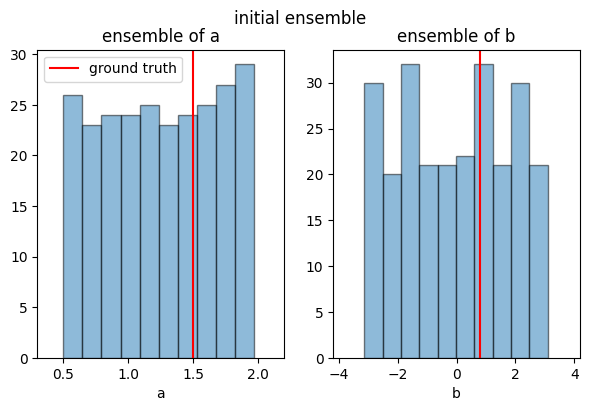

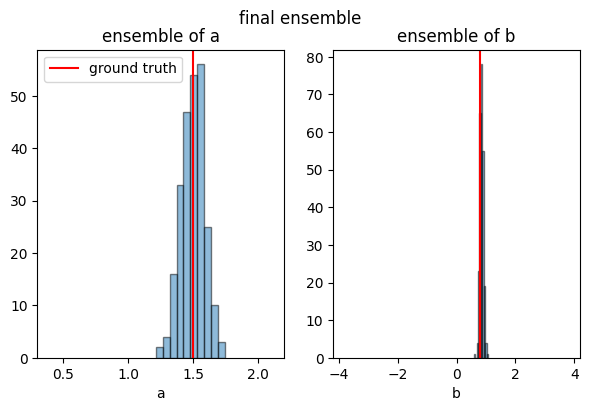

In [23]:
# visual outcomes 
initial_ensemble = ensemble_by_iteration[0]
final_ensemble = ensemble_by_iteration[-1]


plt.figure(figsize = (7,4))
plt.subplot(1,2,1)
plt.suptitle('initial ensemble')
plt.hist(initial_ensemble[:,0], edgecolor = 'k', alpha = 0.5)
plt.axvline(ground_truth_a, color = 'r',label = 'ground truth')
plt.title('ensemble of a')
plt.xlabel('a')
plt.xlim([0.3,2.2])
plt.legend()

plt.subplot(1,2,2)
plt.hist(initial_ensemble[:,1], edgecolor = 'k', alpha = 0.5)
plt.axvline(ground_truth_b, color = 'r', label = 'ground truth')
plt.title('ensemble of b')
plt.xlabel('b')
plt.xlim([-np.pi*4/3,+np.pi*4/3])


plt.figure(figsize = (7,4))
plt.subplot(1,2,1)
plt.suptitle('final ensemble')
plt.hist(final_ensemble[:,0], edgecolor = 'k', alpha = 0.5)
plt.axvline(ground_truth_a, color = 'r',label = 'ground truth')
plt.title('ensemble of a')
plt.xlabel('a')
plt.xlim([0.3,2.2])
plt.legend()

plt.subplot(1,2,2)
plt.hist(final_ensemble[:,1], edgecolor = 'k', alpha = 0.5)
plt.axvline(ground_truth_b, color = 'r', label = 'ground truth')
plt.title('ensemble of b')
plt.xlabel('b')
plt.xlim([-np.pi*4/3,+np.pi*4/3])

In [24]:
# make prediction of ensemble
ensemble_Y = []
for i in range(num_of_ensemble):
    a = initial_ensemble[i,0]
    b = initial_ensemble[i,1]
    Y = forward(a, b)
    ensemble_Y.append(Y)
initial_ensemble_Y = np.array(ensemble_Y)    

ensemble_Y = []
for i in range(num_of_ensemble):
    a = final_ensemble[i,0]
    b = final_ensemble[i,1]
    Y = forward(a, b)
    ensemble_Y.append(Y)
final_ensemble_Y = np.array(ensemble_Y)    



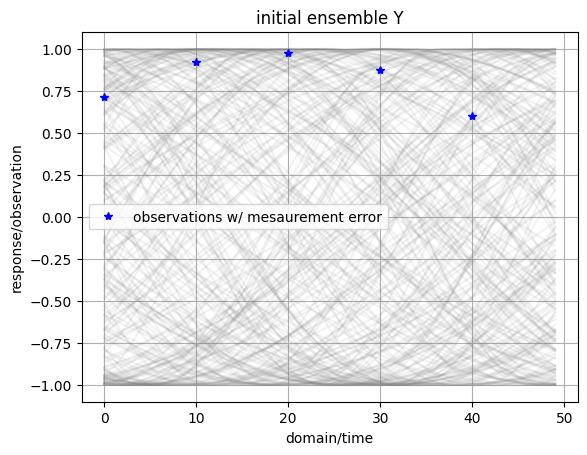

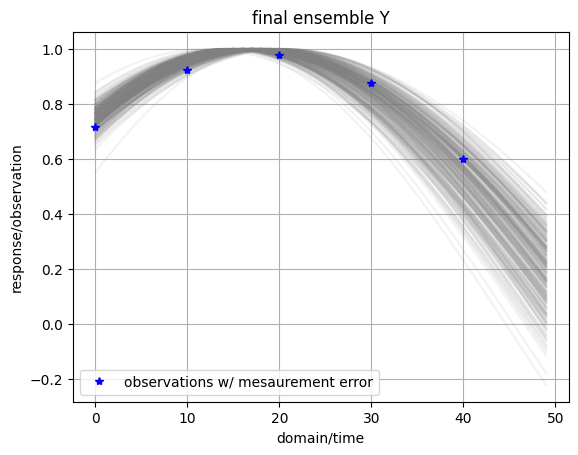

In [25]:
plt.figure()
plt.title('initial ensemble Y')
plt.plot(initial_ensemble_Y.T, color ='gray',alpha = 0.1)
plt.plot(obs_loc, ground_truth_OBS_with_noise, 'b*', label = 'observations w/ mesaurement error')

plt.grid('on')
plt.xlabel('domain/time')
plt.ylabel('response/observation')
plt.legend()

plt.figure()
plt.title('final ensemble Y')
plt.plot(final_ensemble_Y.T, color ='gray',alpha = 0.1)
plt.plot(obs_loc, ground_truth_OBS_with_noise, 'b*', label = 'observations w/ mesaurement error')

plt.grid('on')
plt.xlabel('domain/time')
plt.ylabel('response/observation')
plt.legend()